In [1]:
!pip install -q torch torchvision


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.7 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [3]:
from google.colab import files
uploaded = files.upload()

df = pd.read_csv("/content/cleaned_reviews_5000 (1).csv")  # Dosya adını güncelle
df = df[["translated_text", "label"]].dropna()

texts = df["translated_text"].astype(str).values
labels = df["label"].values


Saving cleaned_reviews_5000 (1).csv to cleaned_reviews_5000 (1) (1).csv


In [4]:
# Tokenizer
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index

# Padding
max_len = 100
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding="post", truncating="post")

# Train/Test
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)


In [5]:
class ReviewDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = ReviewDataset(X_train, y_train)
test_dataset = ReviewDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


In [6]:
class BiLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super(BiLSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # son zaman adımı
        return self.fc(out)

vocab_size = min(len(word_index) + 1, 10000)
model = BiLSTMClassifier(vocab_size=vocab_size, embed_dim=128, hidden_dim=64, output_dim=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


BiLSTMClassifier(
  (embedding): Embedding(10000, 128)
  (lstm): LSTM(128, 64, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(5):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")


Epoch 1, Loss: 84.5208
Epoch 2, Loss: 70.8903
Epoch 3, Loss: 62.0417
Epoch 4, Loss: 57.1219
Epoch 5, Loss: 52.7825


In [8]:
model.eval()
preds = []
true = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        pred_labels = torch.argmax(outputs, dim=1).cpu().numpy()
        preds.extend(pred_labels)
        true.extend(y_batch.numpy())

print("\n📊 Sınıflandırma Raporu (BiLSTM):")
print(classification_report(true, preds, target_names=["SAHTE", "GERÇEK"]))



📊 Sınıflandırma Raporu (BiLSTM):
              precision    recall  f1-score   support

       SAHTE       0.79      0.87      0.82       500
      GERÇEK       0.85      0.76      0.81       500

    accuracy                           0.81      1000
   macro avg       0.82      0.81      0.81      1000
weighted avg       0.82      0.81      0.81      1000



<Figure size 600x400 with 0 Axes>

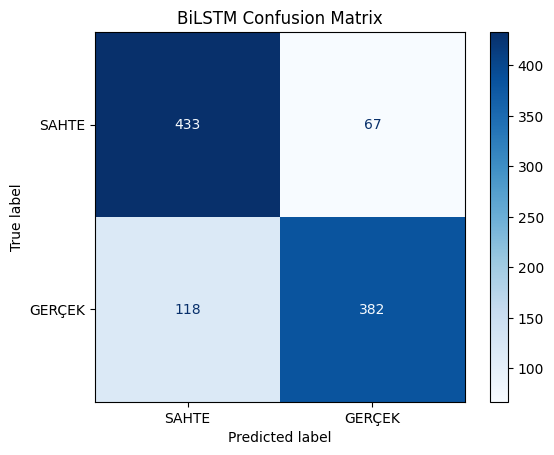

In [9]:
cm = confusion_matrix(true, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["SAHTE", "GERÇEK"])

plt.figure(figsize=(6, 4))
disp.plot(cmap=plt.cm.Blues)
plt.title("BiLSTM Confusion Matrix")
plt.show()
